# IoT GNN Demo

## Env Setup
To use this notebook, a conda environment has to be created beforehand. Commands to create the environment and install the minimal packages:
```bash
conda create -n iot_env python=3.11
conda activate iot_env
conda install pytorch
conda install pandas
conda install scikit-learn
conda install matplotlib
conda install pytorch::torchdata
conda install conda-forge::dgl
```  
Then, the conda environment has to be exported.  
```bash
conda install ipykernel
python -m ipykernel install --user --name iot_env --display-name "Python (iot_env)"
```  
Select the iot_env kernel to run the ipynb.

## Imports

In [1]:
from configuration import *

from models import e_graphsage, fnn_model
from data import IoTDataset
from train import ModelTrainer
import tester

/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Randomized IP Addresses and Ports

### Load Data
This assumes there is a "data" folder under the root of the IoT_GNN repo.  
Datasets can be found at: https://drive.google.com/drive/folders/14t41P09gXTsCqPx3YFN1Pruwb2eZQrkT?usp=share_link

In [3]:
multiclass = True
randomized_ip_train_data = IoTDataset(version=1, multiclass=multiclass)
randomized_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val')
randomized_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test')

### Sanity Check
Running forward pass on the untrained E_GraphSAGE model.  
Only for initial debugging purposes.

In [ ]:
# Local var in order to not modify the graph permanently.
#graph = train_data[0].local_var()
#temp = e_graphsage.E_GraphSAGE(numLayers=2, num_edge_attr=8, dim_node_embed=128, num_classes=5)
#temp.forward(graph)

### Model Initialization

In [26]:
model_egs = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=64,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                                )
model_fnn = fnn_model.TestFNN(num_hidden_layers=3,
                              hidden_layer_widths=[64, 64, 128],  # Should be approximately comparable to EGS
                              num_edge_attr=randomized_ip_train_data.num_features,
                              num_classes=len(randomized_ip_train_data.classes),
                            )

In [19]:
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_training_config = {
        'num_epochs': 175,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_training_config = {
        'num_epochs': 205,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

### Training

In [21]:
# Instantiate Trainer
egs_trainer = ModelTrainer(egs_training_config, randomized_ip_train_data, randomized_ip_val_data)
fnn_trainer = ModelTrainer(fnn_training_config, randomized_ip_train_data, randomized_ip_val_data)

In [23]:
# Train the GNN
egs_trainer.train_model(model_egs, False)

Training E_GraphSAGE_K2: 100%|██████████| 175/175 [02:23<00:00,  1.22epoch/s, train loss=0.6440, validation loss=0.7494, learning rate=1.00e-08, F1 score=0.78038]


In [24]:
# Train the FCNN
fnn_trainer.train_model(model_fnn, False)

Training FCNN_K3: 100%|██████████| 205/205 [02:47<00:00,  1.23epoch/s, train loss=1.1118, validation loss=0.6965, learning rate=1.00e-08, F1 score=0.78197]


### Testing

TODO: Clean up the tester

In [58]:
import importlib
importlib.reload(tester)

<module 'tester' from '/home/rowleyra/IoT_GNN/tester.py'>

In [ ]:
tester_inst = tester.ModelTester(randomized_ip_test_data, False)

[0 1 2 3 4]
{'Benign': {'precision': 0.21767522855899, 'recall': 0.7215007215007215, 'f1-score': 0.33444816053511706, 'support': 2772.0}, 'DDoS': {'precision': 0.46705426356589147, 'recall': 0.4027973258268825, 'f1-score': 0.432552427734744, 'support': 11368.0}, 'DoS': {'precision': 0.3397392260564487, 'recall': 0.5707750505850269, 'f1-score': 0.4259453781512605, 'support': 11367.0}, 'Reconnaissance': {'precision': 0.9883717971552887, 'recall': 0.8253179080217994, 'f1-score': 0.8995154371197166, 'support': 94131.0}, 'Theft': {'precision': 0.05046560528687293, 'recall': 0.4397905759162304, 'f1-score': 0.09054163298302344, 'support': 382.0}, 'accuracy': 0.7575654057657057, 'macro avg': {'precision': 0.4126612241246984, 'recall': 0.5920363163701321, 'f1-score': 0.4366006073047723, 'support': 120020.0}, 'weighted avg': {'precision': 0.856777102846278, 'recall': 0.7575654057657057, 'f1-score': 0.7948087146163377, 'support': 120020.0}}
0.7575654057657057
0.5920363163701321
[[ 2000     0    5

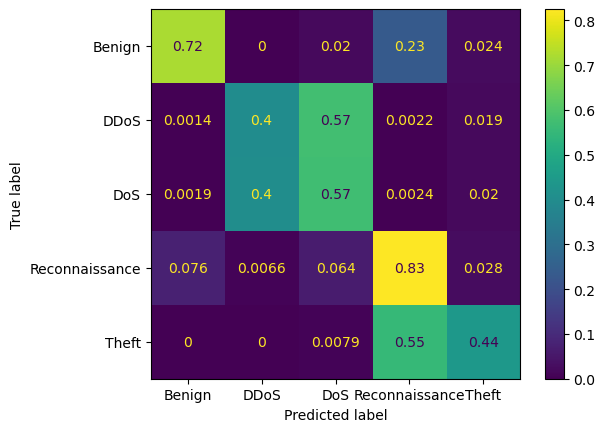

In [ ]:
tester_inst.test_model(model_egs)

[0 1 2 3 4]
{'Benign': {'precision': 0.21832030863586901, 'recall': 0.7961760461760462, 'f1-score': 0.3426752581321326, 'support': 2772.0}, 'DDoS': {'precision': 0.3499604117181314, 'recall': 0.6609781843771991, 'f1-score': 0.4576266025153019, 'support': 11368.0}, 'DoS': {'precision': 0.31874760628111837, 'recall': 0.29286531186768716, 'f1-score': 0.30525881435972674, 'support': 11367.0}, 'Reconnaissance': {'precision': 0.9901907211685836, 'recall': 0.7892723969786787, 'f1-score': 0.8783887634338682, 'support': 94131.0}, 'Theft': {'precision': 0.05497470489038786, 'recall': 0.42670157068062825, 'f1-score': 0.09740065730504929, 'support': 382.0}, 'accuracy': 0.7291118146975504, 'macro avg': {'precision': 0.3864387505388181, 'recall': 0.5931987020160479, 'f1-score': 0.4162700191492158, 'support': 120020.0}, 'weighted avg': {'precision': 0.8451539827373429, 'recall': 0.7291118146975504, 'f1-score': 0.769395865002893, 'support': 120020.0}}
0.7291118146975504
0.5931987020160479
[[ 2207   41

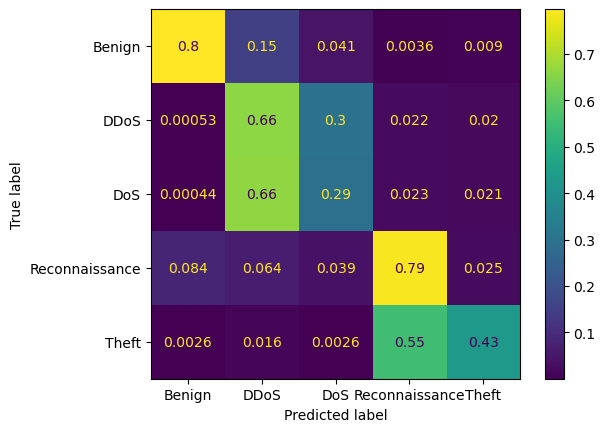

In [ ]:
tester_inst.test_model(model_fnn)

## Non-Randomized IP Addresses and Ports

### Load Data

In [34]:
multiclass = True
orig_ip_train_data = IoTDataset(version=1, multiclass=multiclass, randomize_source_ip=False)
orig_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val', randomize_source_ip=False)
orig_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test', randomize_source_ip=False)

### Model Initialization

In [38]:
model_egs_orig = e_graphsage.E_GraphSAGE(numLayers=2,
                                    dim_node_embed=64,
                                    num_edge_attr=orig_ip_train_data.num_features,
                                    num_classes=len(orig_ip_train_data.classes)
                                    )
model_fnn_orig = fnn_model.TestFNN(num_hidden_layers=3,
                              hidden_layer_widths=[64, 64, 128],  # Should be approximately comparable to EGS
                              num_edge_attr=orig_ip_train_data.num_features,
                              num_classes=len(orig_ip_train_data.classes),
                             )

### Training

In [39]:
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_orig_training_config = {
        'num_epochs': 175,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_orig_training_config = {
        'num_epochs': 205,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

In [40]:
# Instantiate Trainer
egs_orig_trainer = ModelTrainer(egs_training_config, orig_ip_train_data, orig_ip_val_data)
fnn_orig_trainer = ModelTrainer(fnn_training_config, orig_ip_train_data, orig_ip_val_data)

In [41]:
# Train the GNN
egs_orig_trainer.train_model(model_egs, False)

Training E_GraphSAGE_K2: 100%|██████████| 175/175 [00:58<00:00,  2.97epoch/s, train loss=0.5624, validation loss=0.6432, learning rate=1.00e-04, F1 score=0.46487]


In [42]:
# Train the FCNN
fnn_orig_trainer.train_model(model_fnn, False)

Training FCNN_K3: 100%|██████████| 205/205 [02:28<00:00,  1.38epoch/s, train loss=1.0981, validation loss=0.7927, learning rate=1.00e-03, F1 score=0.78149]
